<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-LM-data" data-toc-modified-id="Create-LM-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create LM data</a></span></li><li><span><a href="#Create-classifier-data" data-toc-modified-id="Create-classifier-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create classifier data</a></span></li><li><span><a href="#Save-data" data-toc-modified-id="Save-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save data</a></span></li></ul></div>

This method allows us to build the LM from all reviews - labeled and unlabeled.

https://docs.fast.ai/tutorial.data.html

# Import libs and define global vars

In [31]:
import os
from fastai.text import * 
from fastai import callbacks

# Set the seeds
seedVal = 10
from numpy.random import seed
seed(seedVal)

path = './'
useSubset = True
numSubset = 50

from fastai import torch_core

#torch_core.defaults.device = 'cpu'
torch_core.defaults.device = 'gpu'

# Load and view data

In [32]:
# Set paths to CSV files
dataPath = os.path.join('.', 'datasets', 'imdb_movie_reviews')
labeledTrainData = os.path.join(dataPath, 'labeledTrainData.tsv')
unlabeledTrainData = os.path.join(dataPath, 'unlabeledTrainData.tsv')
testData = os.path.join(dataPath, 'testData.tsv')

# Read CSV files into DFs
labDat = pd.read_csv(labeledTrainData, sep = '\t', header = 0, quoting = 3)
unlabDat = pd.read_csv(unlabeledTrainData, sep = '\t', header = 0, quoting = 3)
testDat = pd.read_csv(testData, sep = '\t', header = 0, quoting = 3)

# Add columns
labDat['type'] = 'train'
unlabDat['type'] = 'unlabeled'
testDat['type'] = 'test'

unlabDat['sentiment'] = None
testDat['sentiment'] = None


# Sanity check
print('labDat.shape :', labDat.shape)
print('unlabDat.shape :', unlabDat.shape)
print('testDat.shape :', testDat.shape)

# Examine results
print("\n")
print('labDat.info() :', labDat.info())
print("\n")
print('unlabDat.info() :', unlabDat.info())
print("\n")
print('testDat.info() :', testDat.info())

labDat.shape : (25000, 4)
unlabDat.shape : (50000, 4)
testDat.shape : (25000, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
type         25000 non-null object
dtypes: int64(1), object(3)
memory usage: 781.3+ KB
labDat.info() : None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
id           50000 non-null object
review       50000 non-null object
type         50000 non-null object
sentiment    0 non-null object
dtypes: object(4)
memory usage: 1.5+ MB
unlabDat.info() : None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
id           25000 non-null object
review       25000 non-null object
type         25000 non-null object
sentiment    0 non-null object
dtypes: object(4)
memory usage: 781.3+ KB


In [33]:
combinedDat = pd.concat(objs=[labDat, unlabDat, testDat], axis=0).reset_index(drop=True)
print(combinedDat.shape)
print("\n")
print(combinedDat.info())

F:\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(100000, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
id           100000 non-null object
review       100000 non-null object
sentiment    25000 non-null object
type         100000 non-null object
dtypes: object(4)
memory usage: 3.1+ MB
None


In [34]:
combinedDat.head()

,id,review,sentiment,type
0,"""5814_8""","""With all this stuff going down at the moment ...",1,train
1,"""2381_9""","""\""The Classic War of the Worlds\"" by Timothy ...",1,train
2,"""7759_3""","""The film starts with a manager (Nicholas Bell...",0,train
3,"""3630_4""","""It must be assumed that those who praised thi...",0,train
4,"""9495_8""","""Superbly trashy and wondrously unpretentious ...",1,train


# Prepare the data

## Create LM data

In [35]:
# Language model data
if useSubset:
    data_lm = (TextList.from_df(df = combinedDat[ combinedDat['type'] == 'train'].iloc[:numSubset,:], cols = 'review')
               .random_split_by_pct(seed=seedVal)
               .label_for_lm()
               .databunch())
else:
    data_lm = (TextList.from_df(df = combinedDat[ combinedDat['type'] == 'train'], cols = 'review')
               .random_split_by_pct(seed=seedVal)
               .label_for_lm()
               .databunch())

In [36]:
data_lm.show_batch()

idx,text
0,"xxbos "" xxmaj the script for this movie was probably found in a xxunk - xxunk xxunk xxunk up by a really old xxunk . xxmaj xxunk an xxunk film with xxunk xxup xxunk . xxmaj for you xxmaj xxunk - xxmaj xxunk xxunk : she has the xxunk of one xxmaj mr. xxmaj xxunk . "" xxbos "" xxmaj xxunk xxmaj xxunk 's xxunk film ' xxmaj the xxmaj"
1,"boogey xxmaj man . ' xxmaj when i found out it was a sequel to the xxunk films i was happy to xxunk out a few xxunk for it ... i should have xxunk better . xxmaj though the opening title is ' xxmaj boogey xxmaj man xxunk , ' this is no sequel to those two far xxunk films i named above . xxmaj well , not totally anyway"
2,""" are most xxunk xxunk of the director who had no acting xxunk xxunk before , and probably none since . xxmaj the plot is xxunk and script xxunk written . xxmaj the xxunk is just xxunk awful . xxmaj the director tries to make the film look all xxunk xxunk by making the camera xxunk around , xxunk xxunk , and with xxunk , but it xxunk nothing ."
3,"xxmaj it 's one thing if that had been an original film that was the director 's first and xxunk . xxmaj but xxunk it 's supposed to be a sequel to film that is no xxunk , but is xxunk sure far more interesting and entertaining than this . xxmaj if there ever is another sequel , which i doubt it , then it needs to xxunk this one"
4,the ' xxmaj xxunk xxmaj xxunk ' three xxunk one . xxmaj xxunk to me he is box office xxunk and xxmaj jeroen xxmaj krabbé is worse than that . xxmaj the poor man 's box office xxunk xxrep 4 . really that is not being xxunk to the xxunk xxunk . xxmaj if the ' xxunk xxmaj man ' is supposed to be some sort of xxunk of the


## Create classifier data

In [37]:
if useSubset:
    data_clas = (TextList.from_df(df = combinedDat[ combinedDat['type'] == 'train'].iloc[:numSubset,:], cols='review', vocab=data_lm.vocab)
                 .random_split_by_pct(valid_pct=0.1, seed=seedVal)
                 .label_from_df(cols='sentiment')
                 .databunch(bs=32))
else:
    data_clas = (TextList.from_df(df = combinedDat[ combinedDat['type'] == 'train'], cols='review', vocab=data_lm.vocab)
                 .random_split_by_pct(valid_pct=0.1, seed=seedVal)
                 .label_from_df(cols='sentiment')
                 .databunch(bs=32))

In [38]:
print("Train DF size:", len(data_clas.train_ds))
print("Valid DF size:", len(data_clas.valid_ds))

Train DF size: 45
Valid DF size: 5


In [39]:
data_clas.show_batch()

text,target
"xxbos "" xxmaj xxunk by the xxunk ( every gay video these xxunk has a xxunk on the xxunk ; this is not xxunk to be xxunk as a good xxunk ) i xxunk xxup ben xxup and xxup arthur without xxunk a thing about it . xxmaj this is my second ( and i xxunk you it will be my last ) purchase of a xxup culture q xxup",0
"xxbos "" i 'll xxunk with the usual xxunk to a certain xxunk xxunk xxunk for his xxunk xxmaj xxunk xxmaj xxunk xxunk , because quite xxunk , to xxunk xxunk with xxunk xxunk xxmaj xxunk xxmaj kornbluth , is just an xxunk to any such director . i will also avoid xxunk the xxunk - on satire ` xxmaj office xxmaj xxunk ' in the same xxunk as this",0
"xxbos "" xxmaj xxunk xxmaj xxunk 's xxunk film ' xxmaj the xxmaj boogey xxmaj man ' is no classic , but it 's an above average xxunk xxunk xxunk that 's worth a look . xxmaj the sequel , xxunk ' xxmaj boogey xxmaj man xxup ii ' is xxunk a waste of time , but at the very least it 's an entertaining one if not xxunk the",0
"xxbos "" ` xxmaj the xxmaj matrix ' was an xxunk xxunk xxunk that was xxunk xxunk but also xxunk thought xxunk in its ` xxmaj xxunk xxmaj xxunk xxunk . xxmaj the xxunk xxunk xxunk xxunk and this sequel does n't xxunk up to its xxunk . xxmaj worse than that , it does n't even xxunk with it . \n\n ` xxmaj reloaded ' xxunk xxunk the screen",0
"xxbos "" xxmaj with all this xxunk going down at the moment with xxup mj i 've xxunk xxunk to his music , watching the xxunk xxunk here and there , watched xxmaj the xxmaj xxunk and watched xxmaj xxunk again . xxmaj maybe i just want to get a certain xxunk into this guy who i thought was really xxunk in the xxunk just to maybe make up my",1


In [40]:
# How can we view the results of the preprocessing?

# Look at record number three...  The FloatItem at the end is the label
#data_clas.train_ds[2]

#data_clas.train_ds.__class__
# fastai.data_block.LabelList
# https://github.com/fastai/fastai/blob/master/fastai/data_block.py

print(data_clas.train_ds.x[1])
print(data_clas.train_ds.y[1])

#len(data_clas.train_ds.x)
#len(data_clas.valid_ds.x)
#print(len(data_clas.train_ds.x) + len(data_clas.valid_ds.x))
#print(len(labDat))

xxbos " " xxmaj the xxmaj classic xxmaj xxunk of the xxmaj xxunk " by xxmaj xxunk xxmaj hines is a very entertaining film that xxunk goes to great xxunk and xxunk to xxunk xxunk xxup xxunk xxup xxunk xxmaj xxunk ' classic book . xxmaj mr. xxmaj hines xxunk in doing so . i , and those who watched his film with me , xxunk the fact that it was not the xxunk , xxunk xxmaj hollywood xxunk that comes out every xxunk , xxunk the xxmaj xxunk version with xxmaj xxunk xxmaj xxunk that had only the xxunk xxunk to the book . xxmaj xxunk , everyone xxunk for different things in a movie . xxmaj those who xxunk themselves as xxunk " critics " look only to xxunk xxunk they can . xxmaj others rate a movie on more xxunk xxunk , like being xxunk , which is why most people never xxunk with the " critics " . xxmaj we xxunk the xxunk xxmaj mr. xxmaj hines put into being xxunk to xxup xxunk xxmaj xxunk ' classic novel , and we found it to be very entertaining . xxmaj this made it xxunk to xxunk what the " cr

## Save data

In [41]:
data_lm.save()
data_clas.save()

In [42]:
data_lm = TextLMDataBunch.load(path)
data_clas = TextClasDataBunch.load(path, bs=32)

# Create and fine tune language model

We can use the data_lm object we created earlier to fine-tune a pretrained language model. fast.ai has an English model available that we can download. We can create a learner object that will directly create a model, download the pretrained weights and be ready for fine-tuning.

epoch,train_loss,valid_loss,accuracy
1,3.807021,3.447389,0.285511


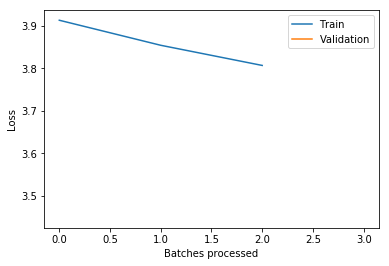

In [43]:
learn = language_model_learner(
    data_lm, 
    pretrained_model=URLs.WT103_1, 
    drop_mult=0.5, 
    callback_fns=[callbacks.SaveModelCallback]
)

learn.fit_one_cycle(1, 1e-2)
learn.recorder.plot_losses()

In [44]:
learn.save_encoder('ft_enc')

---
Next, fine tune the model:

epoch,train_loss,valid_loss,accuracy
1,3.701239,3.404020,0.302557
2,3.620372,3.279838,0.305398
3,3.534713,3.219057,0.335227
4,3.474338,3.170114,0.339489
5,3.423969,3.207299,0.348011


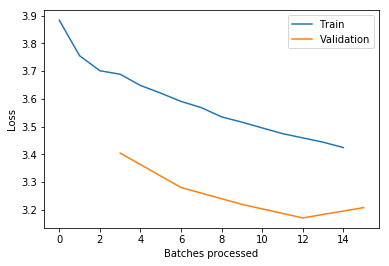

In [45]:
#learn.load_encoder('ft_enc')
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)
learn.recorder.plot_losses()

---
Save the encoder for classification in the next section.

In [46]:
learn.save_encoder('ft_enc')

del learn
torch.cuda.empty_cache()

# Build and train the classifier

In [47]:
learn = text_classifier_learner(data_clas, callback_fns=[callbacks.SaveModelCallback])
learn.load_encoder('ft_enc')

In [48]:
data_clas.show_batch()

text,target
"xxbos "" xxmaj xxunk by the xxunk ( every gay video these xxunk has a xxunk on the xxunk ; this is not xxunk to be xxunk as a good xxunk ) i xxunk xxup ben xxup and xxup arthur without xxunk a thing about it . xxmaj this is my second ( and i xxunk you it will be my last ) purchase of a xxup culture q xxup",0
"xxbos "" i 'll xxunk with the usual xxunk to a certain xxunk xxunk xxunk for his xxunk xxmaj xxunk xxmaj xxunk xxunk , because quite xxunk , to xxunk xxunk with xxunk xxunk xxmaj xxunk xxmaj kornbluth , is just an xxunk to any such director . i will also avoid xxunk the xxunk - on satire ` xxmaj office xxmaj xxunk ' in the same xxunk as this",0
"xxbos "" xxmaj xxunk xxmaj xxunk 's xxunk film ' xxmaj the xxmaj boogey xxmaj man ' is no classic , but it 's an above average xxunk xxunk xxunk that 's worth a look . xxmaj the sequel , xxunk ' xxmaj boogey xxmaj man xxup ii ' is xxunk a waste of time , but at the very least it 's an entertaining one if not xxunk the",0
"xxbos "" ` xxmaj the xxmaj matrix ' was an xxunk xxunk xxunk that was xxunk xxunk but also xxunk thought xxunk in its ` xxmaj xxunk xxmaj xxunk xxunk . xxmaj the xxunk xxunk xxunk xxunk and this sequel does n't xxunk up to its xxunk . xxmaj worse than that , it does n't even xxunk with it . \n\n ` xxmaj reloaded ' xxunk xxunk the screen",0
"xxbos "" xxmaj with all this xxunk going down at the moment with xxup mj i 've xxunk xxunk to his music , watching the xxunk xxunk here and there , watched xxmaj the xxmaj xxunk and watched xxmaj xxunk again . xxmaj maybe i just want to get a certain xxunk into this guy who i thought was really xxunk in the xxunk just to maybe make up my",1


In [49]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.802033,0.682875,0.600000


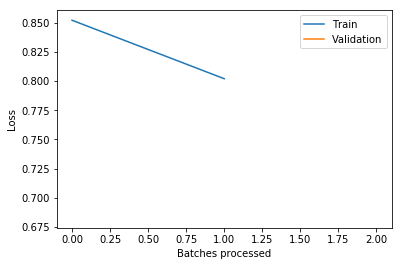

In [50]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy
1,0.672066,0.683427,0.600000


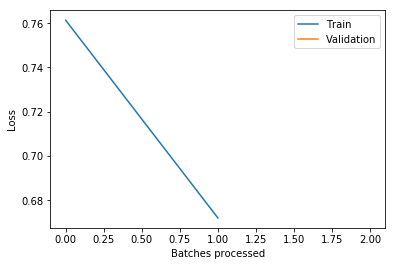

In [51]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy
1,0.774845,0.686152,0.600000
2,0.733409,0.688397,0.600000
3,0.720846,0.686677,0.600000
4,0.730987,0.685883,0.600000
5,0.737296,0.686441,0.600000


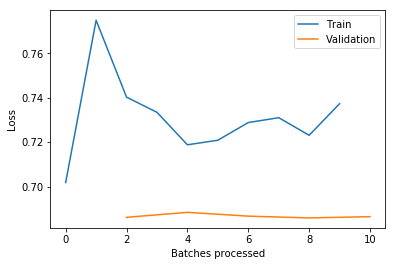

In [52]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(2e-3/100, 2e-3))
learn.recorder.plot_losses()

---

In [53]:
learn.save('imdb_train_clas')

torch.cuda.empty_cache()

In [54]:
learn.show_results(5)

text,target,prediction
"xxbos "" xxmaj xxunk by the xxunk ( every gay video these xxunk has a xxunk on the xxunk ; this is not xxunk to be xxunk as a good xxunk ) i xxunk xxup ben xxup and xxup arthur without xxunk a thing about it . xxmaj this is my second ( and i xxunk you it will be my last ) purchase of a xxup culture q xxup",0,0
"xxbos "" i 'll xxunk with the usual xxunk to a certain xxunk xxunk xxunk for his xxunk xxmaj xxunk xxmaj xxunk xxunk , because quite xxunk , to xxunk xxunk with xxunk xxunk xxmaj xxunk xxmaj kornbluth , is just an xxunk to any such director . i will also avoid xxunk the xxunk - on satire ` xxmaj office xxmaj xxunk ' in the same xxunk as this",0,0
"xxbos "" xxmaj xxunk xxmaj xxunk 's xxunk film ' xxmaj the xxmaj boogey xxmaj man ' is no classic , but it 's an above average xxunk xxunk xxunk that 's worth a look . xxmaj the sequel , xxunk ' xxmaj boogey xxmaj man xxup ii ' is xxunk a waste of time , but at the very least it 's an entertaining one if not xxunk the",0,0
"xxbos "" ` xxmaj the xxmaj matrix ' was an xxunk xxunk xxunk that was xxunk xxunk but also xxunk thought xxunk in its ` xxmaj xxunk xxmaj xxunk xxunk . xxmaj the xxunk xxunk xxunk xxunk and this sequel does n't xxunk up to its xxunk . xxmaj worse than that , it does n't even xxunk with it . \n\n ` xxmaj reloaded ' xxunk xxunk the screen",0,0
"xxbos "" xxmaj with all this xxunk going down at the moment with xxup mj i 've xxunk xxunk to his music , watching the xxunk xxunk here and there , watched xxmaj the xxmaj xxunk and watched xxmaj xxunk again . xxmaj maybe i just want to get a certain xxunk into this guy who i thought was really xxunk in the xxunk just to maybe make up my",1,0


# Predictions

In [55]:
item = list(combinedDat[ combinedDat['type'] == 'test']['review'])[0]
item

'"Naturally in a film who\'s main themes are of mortality, nostalgia, and loss of innocence it is perhaps not surprising that it is rated more highly by older viewers than younger ones. However there is a craftsmanship and completeness to the film which anyone can enjoy. The pace is steady and constant, the characters full and engaging, the relationships and interactions natural showing that you do not need floods of tears to show emotion, screams to show fear, shouting to show dispute or violence to show anger. Naturally Joyce\'s short story lends the film a ready made structure as perfect as a polished diamond, but the small changes Huston makes such as the inclusion of the poem fit in neatly. It is truly a masterpiece of tact, subtlety and overwhelming beauty."'

In [56]:
print(learn.predict(item))
print(int(torch.argmax(learn.predict(item)[2])))

(Category 0, tensor(0), tensor([0.5341, 0.4659]))
0


# Create Kaggle submission

In [60]:
yhats = []
ids = []

for i, row in testDat.iloc[:10,:].iterrows():
    yhats.append(int(torch.argmax(learn.predict(row['review'])[2])))
    ids.append(row['id'])
    
df_results = pd.DataFrame({'id': ids, 'sentiment': yhats}).set_index('id')
print(df_results.head())

# create a submission csv file
df_results.to_csv('kaggle_submission.csv', quoting = csv.QUOTE_NONE) 
# Keras cnn + GloVe + Early Stopping v1.3

            sentiment
id                   
"12311_10"          0
"8348_2"            0
"5828_4"            0
"7186_2"            0
"12128_7"           0


---------------------------------------------------------------------

In [ ]:
data_lm.__class__
method_list = [func for func in dir(data_lm) if callable(getattr(data_lm, func))]
method_list